

# Garbage Classification with EfficientNetV2B2

---
## Project Description
> In this project, we aim to develop a sophisticated **garbage classification system** leveraging the **EfficientNetV2B2** architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.


**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and transfer learning for automated waste sorting.


---
## Challenges and Scope
**Key Challenge:** A notable challenge encountered is the inherent **class imbalance** within the dataset.







    
### Benefits
-  **Reduces training time** — you don't start from scratch.
-  **Leverages learned features** from large datasets (like ImageNet).
-  **Improves performance**, especially with limited data.

---

##  How Does It Work?

1.  Load a pretrained model (e.g., ResNet, EfficientNet).
2.  **Freeze** the pretrained layers (optional).
3.  Add new layers for your custom task.
4.  Train on your new dataset (can also fine-tune).
## EfficientNetV2B2: Transfer Learning Backbone

EfficientNetV2B2 is a mid-sized model from the EfficientNetV2 family developed by **Google**, balancing performance and efficiency.

### ⚙️ Key Features:
- **Fused MBConv blocks** — enhance both training stability and speed.
- **Progressive learning** — enables better generalization with less computation.
- **Improved architecture** — achieves higher accuracy with optimized FLOPs.

---









###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.

In [6]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

## 1.  Explore and Understand the Data
- Load image dataset using tools like `image_dataset_from_directory`.
- Visualize sample images from each class.
- Check the number of images per class to ensure balance.
- Understand image dimensions, color channels, and class labels.



### Load image dataset using tools like `image_dataset_from_directory`.
### Split data into training, validation, and testing sets.

`tf.keras.utils.image_dataset_from_directory(...)`  
Used to load images from a directory where each subfolder represents a class.

---

**path**  
Root directory path containing one subdirectory per class.

**shuffle=True**  
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

**image_size=(128, 128)**  
Resizes all loaded images to this target size (width, height).  
This must match the input size expected by the model.

**batch_size=32**  
Number of images per batch during training.  
This affects memory usage and the frequency of model updates.

**validation_split=False**  
If set to a float (e.g., `0.2`), splits a portion of the data for validation.  
If `False`, no split is applied.

In [3]:
# Step 1 - Set up Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset



Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
  0% 0.00/40.9M [00:00<?, ?B/s]
100% 40.9M/40.9M [00:00<00:00, 1.45GB/s]


In [ ]:
!ls


'kaggle (1).json'   kaggle.json   sample_data   trash-type-image-dataset.zip


In [5]:
import zipfile

with zipfile.ZipFile("trash-type-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("garbage_dataset")



In [ ]:
!kaggle datasets list -s trash


ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
kneroma/tacotrashdataset                                      taco-trash-dataset                                  2992773177  2020-08-13 17:50:18.810000          10666        118  0.7647059        
asdasdasasdas/garbage-classification                          Garbage Classification                                85969666  2018-11-24 05:09:23.977000          51483        567  0.8125           
shivamb/underwater-trash-detection                            Underwater Trash Detection                           181720752  2021-12-14 02:48:14.923000           1601         49  0.875            
bouweceune

In [ ]:
import os

print("ZIP exists:", os.path.exists("trash-type-image-dataset.zip"))


ZIP exists: True


In [ ]:
print("Extracted folder exists:", os.path.exists("garbage_dataset"))
print("Contents inside garbage_dataset:", os.listdir("garbage_dataset") if os.path.exists("garbage_dataset") else "Not Found")


Extracted folder exists: True
Contents inside garbage_dataset: ['TrashType_Image_Dataset']


In [ ]:
dataset_dir = "garbage_dataset"
image_size = (124, 124)
batch_size = 32
seed = 42


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 1 classes.
Using 2022 files for training.


In [ ]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 1 classes.
Using 505 files for validation.


In [ ]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:

print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['TrashType_Image_Dataset']
['TrashType_Image_Dataset']
1


### Visualize sample images from each class.

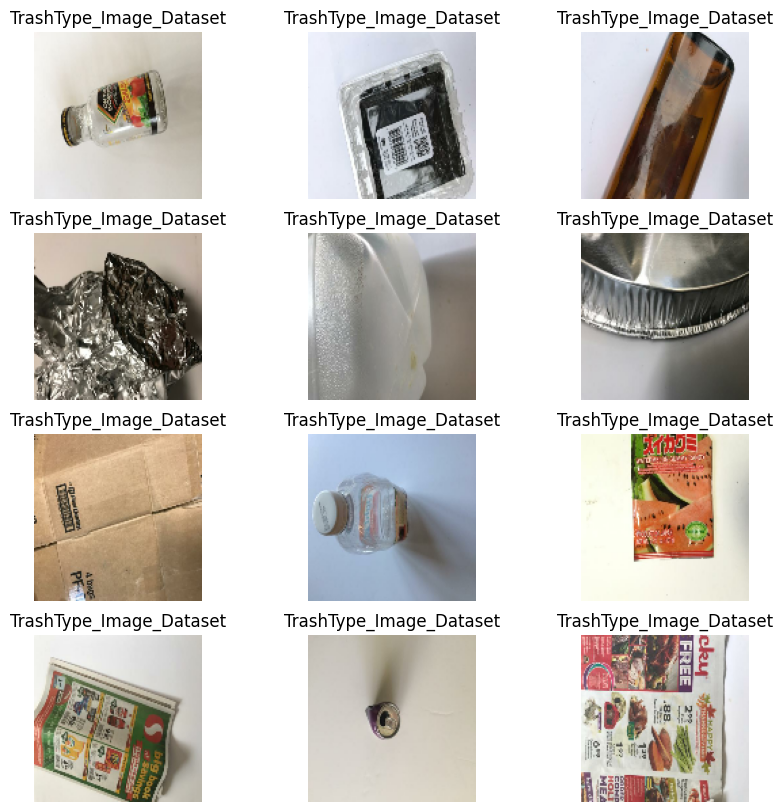

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


In [ ]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts



In [ ]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [ ]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}
{'TrashType_Image_Dataset': 100.0}


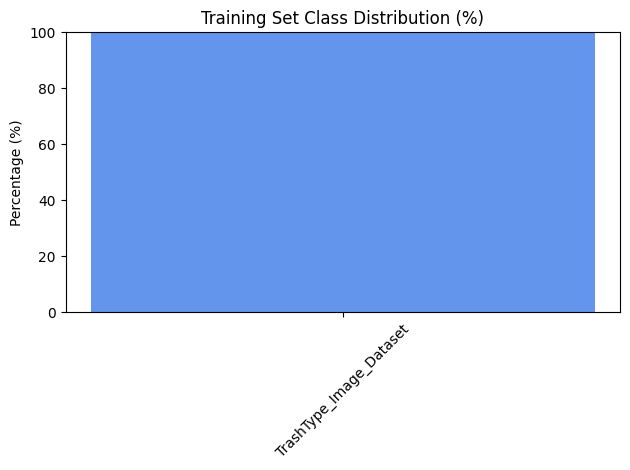

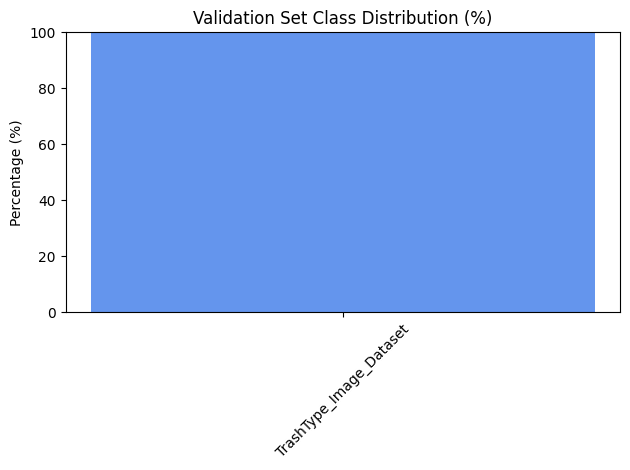

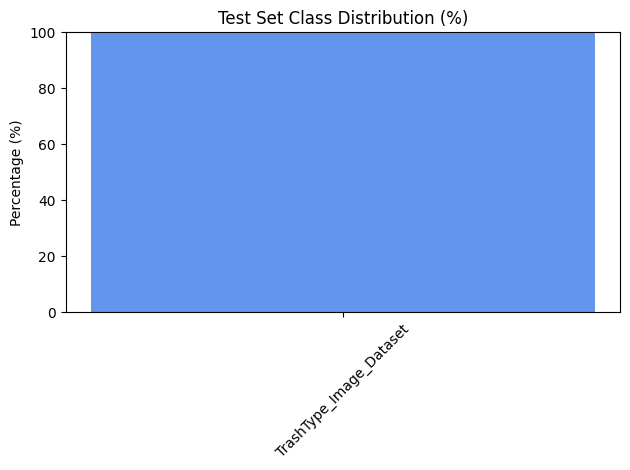

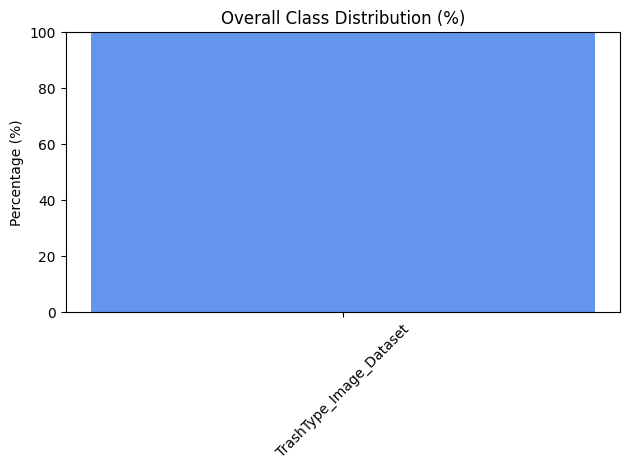

In [ ]:

# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")




#  Inference on Class Imbalance

The **"Garbage Image Dataset"** reveals a noticeable **imbalance** in the distribution of its image categories:

| Category     | Image Count | Updated Distribution |
|--------------|-------------|----------------|
| Cardboard | 403          | 15.09           |
|  Glass     | 501         | 19.96           |
|  Metal     | 410         | 16.68           |
|  Paper     | 594         | 23.82          |
|  Plastic   | 482         | 18.53         |
|  Trash     | 137         |  5.91          |

---

### Analogy:
> Imagine teaching a child to identify animals by showing them **95 pictures of cats** and just **5 pictures of dogs**.  
> They'd probably think **most pets are cats**, right?  
> Similarly, our model sees a lot of "**paper**" and very little "**trash**", which **biases** its understanding.

---

###  Key Problems Caused by Class Imbalance:

#### 1️ **Bias**
- The model may **overpredict common classes** like `"paper"` and **underpredict rare ones** like `"trash"`.

#### 2️ **Generalization Issues**
- If the real-world distribution is more balanced, the model may **fail to generalize** and **misclassify rare classes**.

#### 3️ **Accuracy Deception**
- The model might appear to have **high overall accuracy** just by **predicting the majority class**, while **failing** on underrepresented ones.

---

###  Solution Approaches :
- Use **class weights** to handle imbalanced data in training,
- Apply **data augmentation** to increase training data diversity
---

 **Conclusion**: Always check class distribution. A seemingly "accurate" model might just be **biased** toward the dominant class.





### 🛠️ Addressing Imbalance Using Class Weights:

To tackle our imbalanced image dataset, we'll utilize **class weights**. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from **scikit-learn**, based on the distribution of images in each class. The formula is:

$$
\text{weight(class)} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}}
$$

These computed weights are then passed to the model.


In [ ]:


# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [ ]:

# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)


Class Counts: {0: 2022}
Class Weights: {0: np.float64(1.0)}



## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [ ]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B2`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [ ]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False



35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step



## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`,
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetV2B2**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.


In [ ]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),   # New hidden dense layer
    layers.Dropout(0.4),                    # Increased dropout for regularization
    layers.Dense(6, activation='softmax')   # Output layer for 6 classes
])



In [ ]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 🔁 Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [ ]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 67s 232ms/step - accuracy: 0.5569 - loss: 1.2804 - val_accuracy: 0.9921 - val_loss: 0.4174
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 0.9920 - loss: 0.1891 - val_accuracy: 1.0000 - val_loss: 0.0738
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.0304
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy